### 2.1 CNN Models - Model Training and Development

A multilabel classifier was developed on the entire dataset of 70,000 images (61,370 as traing and 8,630 as validation). Training set was oversampled on cored plaques and CAAs by duplicating the raw images, which resulted in a total of 155,239 images.

#### Architercture of the Convolutional neural network: 
Convolutional layers contained 6 Conv layers (3x3 kernal size, 1 stride, 1 padding, 0.2 dropout) each was followed by a max pooling layer (2x2 kernal size, 2 stride). 
Fully connected layers had 2 hidden layers (512 and 100 neurons, 0.5 dropout), the output layer had three neurons with Sigmoid activation function.

Rectified Linear Unit (ReLU) was used as non-linear activation function for every layer except the output layer.

#### Training: 
The CNN model was trained in the open-source package PyTorch on four NVIDIA GTX 1080 or Titan X graphics processing units (GPUs) using the Adam optimizer with a multi-label soft margin loss function with weight decay (L2 penalty, 0.008). Training proceeded with mini-batches of 64 images with real-time data augmentation including random flips, rotations, zoom, shear, and color jitter.  


The network obtained 0.842, 0.983 and 0.810 AUC-PRC on validation set for cored plaque, diffuse plaque and cerebral amyloid angiopathy (CAA) respectively.

In [1]:
import time, os

import torch
torch.manual_seed(123456789)
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
!pip install numpy==1.16.2
import numpy as np
print(np.__version__)

import matplotlib.pyplot as plt
import pandas as pd
import copy

fastai 1.0.59 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
1.16.2


In [2]:
csv_path = {
    'train': 'labeled/train.csv',
    'dev': 'labeled/validation.csv',
}

DATA_DIR = 'labeled/blobs/'
#NEGATIVE_DIR = 'data/seg/negatives/'
SAVE_DIR = 'models/'
UNLABEL_DIR= 'unlabeled/blobs'
image_classes = ['cored','diffuse','CAA']

In [3]:
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

In [4]:
batch_size = 32
num_workers = 16

# save np.load
#np_load_old = np.load

# modify the default parameters of np.load
#np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

norm = np.load('utils/normalization.npy').item()

In [5]:
from torch.utils.data import Dataset
from PIL import Image

class MultilabelDataset(Dataset):
    def __init__(self, csv_path, img_path, transform=None):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data_info = pd.read_csv(csv_path)
        self.img_path = img_path
        self.transform = transform
        c=torch.Tensor(self.data_info.loc[:,'cored'])
        d=torch.Tensor(self.data_info.loc[:,'diffuse'])
        a=torch.Tensor(self.data_info.loc[:,'CAA'])
        c=c.view(c.shape[0],1)
        d=d.view(d.shape[0],1)
        a=a.view(a.shape[0],1)
        self.raw_labels = torch.cat([c,d,a], dim=1)
        self.labels = (torch.cat([c,d,a], dim=1)>0.99).type(torch.FloatTensor)

    def __getitem__(self, index):
        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.labels[index]
        raw_label = self.raw_labels[index]
        # Get image name from the pandas df
        single_image_name = str(self.data_info.loc[index,'imagename'])
        # Open image
        #try:
        img_as_img = Image.open(self.img_path + single_image_name)
        #except:
        #   img_as_img = Image.open(NEGATIVE_DIR + single_image_name)
        # Transform image to tensor
        if self.transform is not None:
            img_as_img = self.transform(img_as_img)
        # Return image and the label
        return (img_as_img, single_image_label, raw_label, single_image_name)

    def __len__(self):
        return len(self.data_info.index)

In [6]:
def imshow(inp, norm, title=None):
    """Imshow for Tensor."""
    try:
        inp = inp.numpy().transpose((1, 2, 0))
    except:
        inp = inp.transpose((1, 2, 0))
    mean = norm['mean']
    std = norm['std']
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.subplots()
    ax.imshow(inp)
    
    if title is not None:
        ax.set_title(title)
    plt.pause(0.001)

In [7]:
def plot_loss(model):
    fig = plt.figure()
    fig.subplots_adjust(left=2, right = 3, wspace=0.3, bottom = 2, top = 3)
    ax = plt.axes()

    ax.plot(model.train_loss_curve, label='train')
    ax.plot(model.dev_loss_curve, label='dev')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend()

In [8]:
def train_model(model, criterion, criterion_unlab ,optimizer, scheduler, num_epochs=25, gpu_id=None, threshold = 0.6, Lambda= 1):
    since = time.time()

    best_loss = 10000.0
    best_model = copy.deepcopy(model)

    for epoch in range(num_epochs):
        epoch_time = time.time()

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        
        # train phase
        scheduler.step()
        model.train(True)  
        
        running_loss = 0.0
        running_corrects = torch.zeros(len(image_classes))
        
        #############################################################################
                
        # Our Implementation of FixMatch should start here
        # Let loss_lab be the cross-entropy loss of labeled data which is exactly the previous loss
        # let loss_unlab be the cross-entropy loss between the probability disbution of labels attained
        # from inputing a weakly augmented picture and that from inputing a strongly augmented picture
        # reference: https://arxiv.org/pdf/2001.07685.pdf

        #############################################################################

        # Iterate over data.
        for data, weak_data, strong_data in zip(dataloaders_lab['train'], weak_unlabel_loader,strong_unlabel_loader):
            # get the inputs
            inputs, labels, raw_labels, names = data
            weak, _ = weak_data
            strong,_ = strong_data
            
            # wrap them in Variable
            if use_gpu:
                inputs = Variable(inputs.cuda(), requires_grad=True)
                inputs_weak = Variable(weak.cuda(), requires_grad=True)
                inputs_strong= Variable(strong.cuda(), requires_grad=True)

                labels = Variable(labels.cuda(), volatile=True)
            else:
                inputs =  Variable(inputs, requires_grad=True)
                inputs_weak = Variable(weak, requires_grad=True)
                inputs_strong= Variable(strong, requires_grad=True)

                labels = Variable(labels, volatile=True)

            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            outputs = model(inputs)
            loss_lab=criterion(outputs, labels)
            #print(loss_lab.size())
            outputs_weak = model(inputs_weak)  # 128 x 3
            outputs_strong = model(inputs_strong)
            outputs_weak= (outputs_weak > threshold).type(torch.FloatTensor)
            outputs_weak = outputs_weak.cuda()
            loss_unlab=criterion_unlab(outputs_strong, outputs_weak)
            mask = (torch.max(outputs_weak, 1)[0] > threshold)
            loss_unlab = torch.sum(mask * loss_unlab) / (torch.sum(mask)+1e-9)
            # sum the two loss together
            loss = loss_lab + Lambda * loss_unlab
            
            if use_gpu:
                predictions = (F.sigmoid(outputs)>0.5).type(torch.cuda.FloatTensor)
            else:
                predictions = (F.sigmoid(outputs)>0.5).type(torch.FloatTensor)

            # statistics
            running_loss += loss.item()
            running_corrects += torch.sum(predictions==labels, 0).data.type(torch.FloatTensor)

            # backward + optimize only if in training phase

            loss.backward()
            optimizer.step()
        
        
        epoch_loss = running_loss/dataset_sizes['train']
        epoch_acc = running_corrects / dataset_sizes['train']
        
        model.module.train_loss_curve.append(epoch_loss)
        print('train Loss: {:.4f}\n Cored: {:.4f} Diffuse: {:.4f} CAA: {:.4f}'.format(
                 epoch_loss, epoch_acc[0], epoch_acc[1], epoch_acc[2]))
        
        
        # dev phase
        model.train(False)  

        running_loss = 0.0
        running_corrects = torch.zeros(len(image_classes))
            
        # Iterate over data.
        for data in dataloaders_lab['dev']:
            # get the inputs
            inputs, labels, raw_labels, names = data

            if use_gpu:
                inputs = Variable(inputs.cuda(), volatile=True)
                inputs_weak = Variable(weak.cuda(), volatile=True)
                inputs_strong= Variable(strong.cuda(),volatile =True)

                labels = Variable(labels.cuda(), volatile=True)
            else:
                inputs =  Variable(inputs, volatile=True)
                inputs_weak = Variable(weak, volatile=True)
                inputs_strong= Variable(strong,volatile =True)

                labels = Variable(labels, volatile=True)

            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            if use_gpu:
                predictions = (F.sigmoid(outputs)>0.5).type(torch.cuda.FloatTensor)
            else:
                predictions = (F.sigmoid(outputs)>0.5).type(torch.FloatTensor)

            # statistics
            running_loss += loss.item()
            running_corrects += torch.sum(predictions==labels, 0).data.type(torch.FloatTensor)

        epoch_loss = running_loss/dataset_sizes['dev']
        epoch_acc = running_corrects / dataset_sizes['dev']
 
        model.module.dev_loss_curve.append(epoch_loss)

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model = copy.deepcopy(model)
            print('best loss: ', epoch_loss)

        print('dev Loss: {:.4f}\n Cored: {:.4f} Diffuse: {:.4f} CAA: {:.4f}'.format(
            epoch_loss, epoch_acc[0], epoch_acc[1], epoch_acc[2]))

        epoch_end = time.time() - epoch_time
        print('train, Epoch time {:.0f}m {:.0f}s'.format(
                epoch_end // 60, epoch_end % 60))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return best_model

In [9]:
def dev_model(model, criterion, phase='dev'):
    phase = phase
    since = time.time()
    
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers)
              for x in [phase]}

    model.train(False) 

    running_loss = 0.0
    running_corrects = torch.zeros(len(image_classes))
    running_preds = torch.Tensor(0)          # confidence score
    running_predictions = torch.Tensor(0)    # classification prediction
    running_labels = torch.Tensor(0)
    running_raw_labels = torch.Tensor(0)

    # Iterate over data.
    loss= 0
    for data in dataloaders[phase]:
        # get the inputs
        inputs, labels, raw_labels, names = data
        running_labels = torch.cat([running_labels, labels])
        running_raw_labels = torch.cat([running_raw_labels, raw_labels])

        # wrap them in Variable
        if use_gpu:
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        # forward
        outputs = model(inputs)
        preds = F.sigmoid(outputs) #posibility for each class
        if use_gpu:
            predictions = (preds>0.5).type(torch.cuda.FloatTensor)
        else:
            predictions = (preds>0.5).type(torch.FloatTensor)
        
        loss = criterion(outputs, labels)

        preds = preds.data.cpu()
        predictions = predictions.data.cpu()
        labels = labels.data.cpu()

        # statistics
        running_loss += loss.data[0]
        running_corrects += torch.sum(predictions==labels, 0).type(torch.FloatTensor)
        running_preds = torch.cat([running_preds, preds])
        running_predictions = torch.cat([running_predictions, predictions])


    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects / dataset_sizes[phase]

    print('{} Loss: {:.4f}\n Cored: {:.4f} Diffuse: {:.4f} CAA: {:.4f}'.format(
                phase, epoch_loss, epoch_acc[0], epoch_acc[1], epoch_acc[2]))

    print()

    time_elapsed = time.time() - since
    print('Prediction complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return epoch_acc, running_preds, running_predictions, running_labels

In [10]:
class Net(nn.Module):

    def __init__(self, fc_nodes=512, num_classes=3, dropout=0.5):
        super(Net, self).__init__()
        
        self.drop = 0.2
     
        self.features = nn.Sequential(nn.Conv2d(3, 64, 3, padding=1),
                                      nn.Dropout2d(self.drop),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      
                                      nn.Conv2d(64, 64, 3, padding=1),
                                      nn.Dropout2d(self.drop),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      
                                      nn.Conv2d(64, 128, 3, padding=1),
                                      nn.Dropout2d(self.drop),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      
                                      nn.Conv2d(128, 256, 3, padding=1),
                                      nn.Dropout2d(self.drop),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      
                                      nn.Conv2d(256, 256, 3, padding=1),
                                      nn.Dropout2d(self.drop),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      
                                      nn.Conv2d(256, 512, 3, padding=1),
                                      nn.Dropout2d(self.drop),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),)
        
        self.classifier = nn.Sequential(nn.Linear(512 * 4 * 4, fc_nodes),
                                        nn.ReLU(True),
                                        nn.Dropout(p=dropout),
                                        nn.Linear(fc_nodes, 100),
                                        nn.ReLU(True),
                                        nn.Dropout(p=dropout),
                                        nn.Linear(100, num_classes))
        
        self.train_loss_curve = []
        self.dev_loss_curve = []

    def forward(self, x):
 
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x


In [11]:
from randaugment import RandAugmentMC

strong_augumentation = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(180),
            #transforms.ColorJitter(brightness=0.1, contrast=0.2,saturation=0.2, hue=0.02),
            #transforms.RandomAffine(0, translate=(0.05,0.05), scale=(0.9,1.1), shear=10),
            #transforms.RandomCrop(size=32,padding=int(32*0.125),padding_mode='reflect'),
            RandAugmentMC(n=2, m=10),
            transforms.ToTensor(),
            transforms.Normalize(norm['mean'], norm['std'])])


weak_augumentation = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(180),
            #transforms.ColorJitter(brightness=0.1, contrast=0.2,saturation=0.2, hue=0.02),
            #transforms.RandomAffine(0, translate=(0.05,0.05), scale=(0.9,1.1), shear=10),
            #transforms.RandomCrop(size=32,padding=int(32*0.125),padding_mode='reflect'),
            transforms.ToTensor(),
            transforms.Normalize(norm['mean'], norm['std'])])

weak_unlabel = datasets.ImageFolder(UNLABEL_DIR, transform = weak_augumentation)
strong_unlabel = datasets.ImageFolder(UNLABEL_DIR, transform = strong_augumentation)
weak_unlabel_loader = torch.utils.data.DataLoader(weak_unlabel, batch_size=2*batch_size, shuffle=False)
strong_unlabel_loader = torch.utils.data.DataLoader(strong_unlabel, batch_size=2*batch_size, shuffle=False)

'''Example
for epoch in range(epoch_num):
    
    for weak_unlabel_inputs, _ in weak_unlabel_loader:
    '''

'Example\nfor epoch in range(epoch_num):\n    \n    for weak_unlabel_inputs, _ in weak_unlabel_loader:\n    '

In [12]:
data_transforms = {
    'train':  transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        #transforms.RandomCrop(size=32,padding=int(32*0.125),padding_mode='reflect'),
        transforms.RandomRotation(180),
        transforms.ColorJitter(brightness=0.1, contrast=0.2,saturation=0.2, hue=0.02),
        transforms.RandomAffine(0, translate=(0.05,0.05), scale=(0.9,1.1), shear=10),
        transforms.ToTensor(),
        transforms.Normalize(norm['mean'], norm['std'])
    ]),
    'dev': 
transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(norm['mean'], norm['std'])
    ]),
}

weak_unlabel = datasets.ImageFolder(UNLABEL_DIR, transform = weak_augumentation)
strong_unlabel = datasets.ImageFolder(UNLABEL_DIR, transform = strong_augumentation)
weak_unlabel_loader = torch.utils.data.DataLoader(weak_unlabel, batch_size=2*batch_size, shuffle=False)
strong_unlabel_loader = torch.utils.data.DataLoader(strong_unlabel, batch_size=2*batch_size, shuffle=False)


image_datasets = {x: MultilabelDataset(csv_path[x], DATA_DIR, data_transforms[x])
                  for x in ['train', 'dev']}
        
dataloaders_lab = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers)
                  for x in ['dev', 'train']}

#dataloader_unlab_weak = [x  for x, _ in weak_unlabel_loader]
#dataloader_unlab_strong = [ x  for x, _ in strong_unlabel_loader]

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'dev']}

use_gpu = torch.cuda.is_available()

dataset_sizes

{'train': 70000, 'dev': 8630}

In [13]:
len(weak_unlabel)

202565

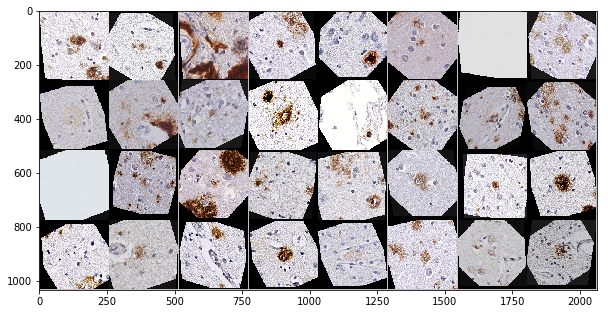

In [14]:
# Get a batch of training data
inputs, labels, raw_labels, names = next(iter(dataloaders_lab['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, norm)

In [15]:
weight = torch.FloatTensor([1,1,1])
model = Net()

if use_gpu:
    print('gpu')
    weight = weight.cuda()
    model = nn.DataParallel(model, device_ids=[0])
    model = model.cuda()
    
criterion = nn.MultiLabelSoftMarginLoss(weight=weight)
criterion_unlab = torch.nn.MultiLabelSoftMarginLoss(weight=None,
                                                    size_average=None, 
                                                    reduce=None, 
                                                    reduction='none')
optimizer = optim.Adam(model.parameters(), lr=0.00008, weight_decay=0.008)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.4)
#gamma

gpu


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
best_model = train_model(model, criterion, criterion_unlab, optimizer, exp_lr_scheduler, num_epochs=60, threshold =0.7, Lambda=0.8)

Epoch 0/59
----------


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use t

train Loss: 0.2532
 Cored: 0.9640 Diffuse: 0.8295 CAA: 0.9664


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:104: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:105: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:106: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:108: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


best loss:  0.1420060396539792
dev Loss: 0.1420
 Cored: 0.9559 Diffuse: 0.9126 CAA: 0.9854
train, Epoch time 23m 27s

Epoch 1/59
----------
train Loss: 0.1915
 Cored: 0.9640 Diffuse: 0.8913 CAA: 0.9665
best loss:  0.1316050055129227
dev Loss: 0.1316
 Cored: 0.9559 Diffuse: 0.9344 CAA: 0.9857
train, Epoch time 23m 30s

Epoch 2/59
----------
train Loss: 0.1798
 Cored: 0.9640 Diffuse: 0.8993 CAA: 0.9678
best loss:  0.1290767818585746
dev Loss: 0.1291
 Cored: 0.9559 Diffuse: 0.9358 CAA: 0.9888
train, Epoch time 23m 25s

Epoch 3/59
----------
train Loss: 0.1713
 Cored: 0.9640 Diffuse: 0.9019 CAA: 0.9687
best loss:  0.12736149785278295
dev Loss: 0.1274
 Cored: 0.9559 Diffuse: 0.9365 CAA: 0.9907
train, Epoch time 23m 28s

Epoch 4/59
----------
train Loss: 0.1652
 Cored: 0.9640 Diffuse: 0.9051 CAA: 0.9704
best loss:  0.12651626077477376
dev Loss: 0.1265
 Cored: 0.9559 Diffuse: 0.9367 CAA: 0.9911
train, Epoch time 23m 27s

Epoch 5/59
----------
train Loss: 0.1568
 Cored: 0.9640 Diffuse: 0.9066 

In [ ]:
torch.save(best_model, SAVE_DIR+'CNN_Ssl_FixMatch.pkl')

In [ ]:
plot_loss(model.module)